In [5]:
import os
import re
#import ROOT
import hist
import pickle
import mplhep as hep
from glob import glob
import numpy as np
import awkward as ak
from tabulate import tabulate
from IPython import embed
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import iminuit
from iminuit import Minuit
from iminuit.cost import LeastSquares
hep.style.use("CMS")
print("iminuit version:", iminuit.__version__)
import itertools
from collections import defaultdict
import glob

iminuit version: 2.30.1


In [6]:
## Load the data_storage from the previous run

if os.path.exists("data_storage.pkl"):
    with open("data_storage.pkl", "rb") as file:
        data_storage_dict = pickle.load(file)
    # Convert to defaultdict (optional, if you need default values)
    data_storage = defaultdict(lambda: {"values": [], "err": [], "colour": None, "location": None})
    # Load the data and update it
    data_storage.update(data_storage_dict)
else:
    data_storage = defaultdict(lambda: {"values": [], "err": [], "colour": None, "location": None})

#data_storage

Saved .pickle file: INPUT/Run3_preEE_2022_full_18_feb_fastMTT_GammaH0p004/combined_pickles
Saved .pickle file: INPUT/Run3_preEE_2022_full_18_feb_fastMTT_GammaH0p004/combined_pickles
Saved .pickle file: INPUT/Run3_preEE_2022_full_18_feb_fastMTT_GammaH0p004/combined_pickles
Processing tag: IPPV
Checking file: INPUT/Run3_preEE_2022_full_18_feb_fastMTT_GammaH0p004/combined_pickles/shifted_hist__PhiCP_IPDP.pickle, looking for tag: IPPV
Skipping: INPUT/Run3_preEE_2022_full_18_feb_fastMTT_GammaH0p004/combined_pickles/shifted_hist__PhiCP_IPDP.pickle
Checking file: INPUT/Run3_preEE_2022_full_18_feb_fastMTT_GammaH0p004/combined_pickles/shifted_hist__PhiCP_IPPV.pickle, looking for tag: IPPV
Take file: INPUT/Run3_preEE_2022_full_18_feb_fastMTT_GammaH0p004/combined_pickles/shifted_hist__PhiCP_IPPV.pickle
>>>---- Processing file : INPUT/Run3_preEE_2022_full_18_feb_fastMTT_GammaH0p004/combined_pickles/shifted_hist__PhiCP_IPPV.pickle --->>>
>>>---- IPPV fastMTT
cat :  $\mu a^{3\pi}_{1}$
hyp :  cp_even

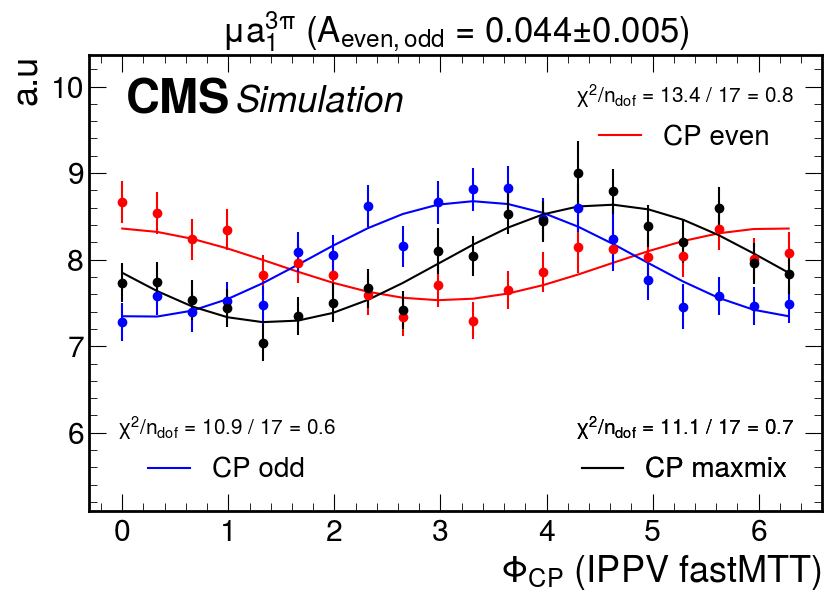

Checking file: INPUT/Run3_preEE_2022_full_18_feb_fastMTT_GammaH0p004/combined_pickles/shifted_hist__PhiCP_IPIP.pickle, looking for tag: IPPV
Skipping: INPUT/Run3_preEE_2022_full_18_feb_fastMTT_GammaH0p004/combined_pickles/shifted_hist__PhiCP_IPIP.pickle


In [16]:
## Define the categories and tags
#tags = ["IPIP", "IPDP", "IPPV"]
tags = ["IPPV"]

catdict = {
    #r"$\mu \pi$"     : 20014002,
    #r"$\mu \rho$"    : 20014004,
    r"$\mu a^{3\pi}_{1}$" : 20014008,
}

shiftdict = {
    "cp_even": {"shift": 150, "colour": "red", "location": "upper right"},
    "cp_odd": {"shift": 151, "colour": "blue", "location": "lower left"},
    "cp_maxmix": {"shift": 0, "colour": "black", "location": "lower right"},
}

simpledict = {
    r"$\mu \pi$"     : "mupi",
    r"$\mu \rho$"    : "murho",
    r"$\mu a^{3\pi}_{1}$" : "mua13pr",
}

## Combine the Pickle files if needed
#dir_name = "Run3_preEE_2022_full_18_feb_fastMTT_mH0p01"
dir_name = "Run3_preEE_2022_full_18_feb_fastMTT_GammaH0p004"
#dir_name = "control_plots_full_config"

subdirs = [
    "h_ggf_tautau_uncorrelatedDecay_CPodd_Filtered_ProdAndDecay",
    "h_ggf_tautau_uncorrelatedDecay_MM_Filtered_ProdAndDecay",
    "h_ggf_tautau_uncorrelatedDecay_SM_Filtered_ProdAndDecay"
]
#subdirs = ["this"]

base_dir = os.path.join("INPUT", dir_name)
place_combined_pickels = os.path.join(base_dir, "combined_pickles")
output_dir = os.path.join("OUTPUT", dir_name)
os.makedirs(place_combined_pickels, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)


file_names = set(os.path.basename(f) for f in glob.glob(os.path.join(base_dir, subdirs[0], "*.pickle")))


for file_name in file_names:
    combined_hist = None

    for subdir in subdirs:
        file_path = os.path.join(base_dir, subdir, file_name)
        
        with open(file_path, 'rb') as f:
            hist = pickle.load(f)
        
        if combined_hist is None:
            combined_hist = hist
        else:
            combined_hist += hist
    
    output_path = os.path.join(place_combined_pickels, file_name)
    
    with open(output_path, 'wb') as f:
        pickle.dump(combined_hist, f)

    print(f"Saved .pickle file: {place_combined_pickels}")

## Loop over the tags and categories, do the fitting and save the results
for tag in tags:  # Loop over tags
    print(f"Processing tag: {tag}")
    file_list = glob.glob(f"{base_dir}/combined_pickles/shifted_hist__*.pickle", recursive=True)
    
    for file in file_list:
        print(f"Checking file: {file}, looking for tag: {tag}")
        if tag in file:
            print(f"Take file: {file}")
        if tag not in file:
            print(f"Skipping: {file}")
            continue

        if "Gen" in file:
            is_gen = "Gen"
        elif "fastMTT" in dir_name and "PV" in tag:
            is_gen = "fastMTT"
        else:
            is_gen = "Reco"

        
        tag_kind = f"{tag} {is_gen}"
        print(f">>>---- Processing file : {file} --->>>")
        print(f">>>---- {tag_kind}")
        fileptr = open(file, 'rb')
        data = pickle.load(fileptr)
        fileptr.close()

        if not hasattr(data, 'axes'):
            print(f"Warning: 'axes' not found in {file}. Skipping...")
            continue

        axes = data.axes
        category_axis  = axes['category']
        shift_axis = axes['shift']


        cparray = {}
        for ccat, cval in catdict.items():
            for shift, props in shiftdict.items():
                hypothesis = shift
                colour = props["colour"]
                location = props["location"]

                if cval not in category_axis:
                    print(f"WARNING : {cval} not in categories")
                    continue
                
                shift_index = shift_axis.index(props["shift"])
                values = data[category_axis.index(cval), :, shift_index, :].values()
                # https://github.com/oponcet/CPinHToTauTau/blob/FF_dev_project/script_FF/fake_factor_derivation/src/input_processing.py#L133
                errors = data[category_axis.index(cval), :, shift_index, :].variances() ** 0.5

                # store in data_storage
                if ccat not in cparray:
                    cparray[ccat] = {}
                    
                cparray[ccat][hypothesis] = {
                    "values": values,
                    "errors": errors,
                    "colour": colour,
                    "location": location,
                }

        def model(x, a, b, c):
            return a*np.cos(x+c) + b

        def fit(x, y, err=0.05, model=model):
            lsq = LeastSquares(x, y, err, model)
            m = Minuit(lsq, a=0.1, b=0.1, c=1.0)
            #m.scan(ncall=100)
            m.fixed = False
            m.migrad()  # finds minimum of least_squares function
            m.hesse()  # accurately computes uncertainties
            return m, err, m.values["a"], m.errors["a"], m.values["b"], m.errors["b"], m.values["c"]

        def comp_asymmetry(arr1, arr2):
            # https://github.com/Ksavva1021/TIDAL/blob/656f992ae056b3fed0061f2b3efb49905c39834d/CP_Tools/scripts/assymetry.py#L26
            return (1/arr1.size)*np.sum(np.abs((arr1-arr2)/(arr1+arr2)))

        def comp_asymmetry_error(arr1, arr2, err1, err2): #arr = array of values, err = array of errors
            # Terms for partial derivatives
            denom = arr1 + arr2
            term1 = err1 * np.abs((2 * arr2) / (denom**2))
            term2 = err2 * np.abs((2 * arr1) / (denom**2))
            # Propagate errors
            sigma_A = np.sqrt(np.sum(term1**2 + term2**2)) / arr1.size
            return sigma_A

        x = np.linspace(0., 2*np.pi, 20)


        

        for cat, val in cparray.items():  # Loop over categories (DMs)
            print("cat : ", cat)
            if len(val) == 0:
                print(f"WARNING : {cat} has an empty dict")
                continue
            
            plt.figure(figsize=(8.9, 6.6))
            hep.cms.text("Simulation", loc=1)

            # Initialise category in data_storage if not already there
            if cat not in data_storage:
                data_storage[cat] = {
                    f"{dir_name}": {},  # Initialize the tags key to store per-category tags
                }
            if dir_name not in data_storage[cat]:
                data_storage[cat][dir_name] = {}
            if tag_kind not in data_storage[cat][dir_name]:
                data_storage[cat][dir_name][tag_kind] = {}

            for hyp, shift_props in shiftdict.items():  # Loop over hypotheses
                shift, colour, location = shift_props["shift"], shift_props["colour"], shift_props["location"]
                print("hyp : ", hyp, "shift_props :", shift_props)

                hypothesis_zip = val[hyp]  # gives per hypothesis: {'values': array, 'errors': array, '...': 'black', 'location': '...'}
                hypothesis_fit_vals, hypothesis_fit_errs = np.ravel(hypothesis_zip["values"]), np.ravel(hypothesis_zip["errors"])

                # Fit the Hypothesis
                m, err, a, sigma_a, b, sigma_b, c = fit(x, hypothesis_fit_vals, hypothesis_fit_errs)


                if tag_kind not in data_storage[cat][dir_name]:  
                    data_storage[cat][dir_name][tag_kind] = {}  # Initialise tag_kind in [tag_kind] if not already there

                data_storage[cat][dir_name][tag_kind][hyp] = {  # Directly use hypothesis name
                    "values": np.array(hypothesis_fit_vals), #hypothesis_fit_vals.tolist(),
                    "err": err,
                    "colour": colour,
                    "location": location,
                    #"m": m,
                }


                # Plot the results
                plt.errorbar(x, hypothesis_fit_vals, hypothesis_fit_errs, fmt="o", color=colour)
                fit_curve = model(x, *m.values)
                plt.plot(x, fit_curve, color=colour)
                fit_info = [
                    f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.1f} / {m.ndof:.0f} = {m.fmin.reduced_chi2:.1f}",
                ]
                legend_handle = Line2D([0], [0], color=colour, label=f"CP {hyp[3:]}")
                legend = plt.legend(handles=[legend_handle], title="\n".join(fit_info), frameon=False, loc=location, fontsize=20, title_fontsize=15)
                plt.gca().add_artist(legend)

                fit_y_min = np.min(fit_curve)
                fit_y_max = np.max(fit_curve)
                y_min = fit_y_min - 0.3 * fit_y_min
                y_max = fit_y_max + 0.2 * fit_y_max
                plt.ylim(y_min, y_max)

            for category1, category2 in itertools.combinations(shiftdict.keys(), 2):  # Loop over pairs of hypotheses (asymmetry calculations)
                hypothesis1 = np.ravel(val[category1]["values"])
                hypothesis2 = np.ravel(val[category2]["values"])
                error1 = np.ravel(val[category1]["errors"])
                error2 = np.ravel(val[category2]["errors"])

                asymmetry = comp_asymmetry(hypothesis1, hypothesis2)
                asymmetry_error = comp_asymmetry_error(hypothesis1, hypothesis2, error1, error2)

                combo_name = f"{category1}_vs_{category2}"
                print("combo_name : ", combo_name)

                if combo_name not in data_storage[cat][dir_name][tag_kind]:
                    data_storage[cat][dir_name][tag_kind][combo_name] = {}  # Initialize combo_name under tag_kind if not already there

                # Store the asymmetry result for this category and tag_kind
                data_storage[cat][dir_name][tag_kind][combo_name]["asymmetry_val"] = asymmetry
                data_storage[cat][dir_name][tag_kind][combo_name]["asymmetry_error"] = asymmetry_error


            # Save the final plot
            asymmetry_val_even_odd = data_storage[cat][dir_name][tag_kind]["cp_even_vs_cp_odd"]["asymmetry_val"]
            asymmetry_error_even_odd = data_storage[cat][dir_name][tag_kind]["cp_even_vs_cp_odd"]["asymmetry_error"]
            asymmetry_val_even_odd_rounded = round(asymmetry_val_even_odd, 3)
            asymmetry_error_even_odd_rounded = round(asymmetry_error_even_odd, 3)

            x_label = r"$\Phi_{CP}$" + f" ({tag_kind})"
            #if is_gen == "Gen":
            #    x_label += " (Gen)"

            title_name = simpledict.get(cat, cat)

            plt.xlabel(x_label)
            plt.ylabel("a.u")
            plt.title(f"{cat} ($A_{{even,odd}}$ = {asymmetry_val_even_odd_rounded}$\\pm${asymmetry_error_even_odd_rounded})", fontsize=25, loc='center')
            plt.tight_layout()
            plt.savefig(f"{output_dir}/{tag_kind}_{title_name}_{is_gen}.pdf", dpi=300)
            plt.show()
            

In [8]:
def print_nested_keys(d, prefix=""):
    if isinstance(d, dict):
        for key, value in d.items():
            new_prefix = f"{prefix} -> {key}" if prefix else key
            print(new_prefix)
            print_nested_keys(value, new_prefix)

print_nested_keys(data_storage)

$\mu-\pi$
$\mu-\pi$ -> Run3_preEE_2022_full_18_feb_fastMTT_mH0p01
$\mu-\pi$ -> Run3_preEE_2022_full_18_feb_fastMTT_mH0p01 -> IPIP Gen
$\mu-\pi$ -> Run3_preEE_2022_full_18_feb_fastMTT_mH0p01 -> IPIP Gen -> cp_even
$\mu-\pi$ -> Run3_preEE_2022_full_18_feb_fastMTT_mH0p01 -> IPIP Gen -> cp_even -> values
$\mu-\pi$ -> Run3_preEE_2022_full_18_feb_fastMTT_mH0p01 -> IPIP Gen -> cp_even -> err
$\mu-\pi$ -> Run3_preEE_2022_full_18_feb_fastMTT_mH0p01 -> IPIP Gen -> cp_even -> colour
$\mu-\pi$ -> Run3_preEE_2022_full_18_feb_fastMTT_mH0p01 -> IPIP Gen -> cp_even -> location
$\mu-\pi$ -> Run3_preEE_2022_full_18_feb_fastMTT_mH0p01 -> IPIP Gen -> cp_odd
$\mu-\pi$ -> Run3_preEE_2022_full_18_feb_fastMTT_mH0p01 -> IPIP Gen -> cp_odd -> values
$\mu-\pi$ -> Run3_preEE_2022_full_18_feb_fastMTT_mH0p01 -> IPIP Gen -> cp_odd -> err
$\mu-\pi$ -> Run3_preEE_2022_full_18_feb_fastMTT_mH0p01 -> IPIP Gen -> cp_odd -> colour
$\mu-\pi$ -> Run3_preEE_2022_full_18_feb_fastMTT_mH0p01 -> IPIP Gen -> cp_odd -> location
$\m

# Compare the asymmetries + errors

In [114]:
colour_palette = ['#998ec3', '#d78a7e', '#fec44f']

def compare_asymmetries(data_storage, selected_cats=None, selected_datasets=None, selected_tags=None, selected_keys=None):
    if selected_cats is None:
        selected_cats = list(data_storage.keys())
    if selected_datasets is None:
        selected_datasets = [ds for cat in selected_cats for ds in data_storage[cat].keys()]
    if selected_keys is None:
        selected_keys = [key for cat in selected_cats for ds in selected_datasets for tag in selected_tags for key in data_storage[cat][ds].get(tag, {}).keys()]

    print("selected_cats", selected_cats)
    print("selected_datasets:", selected_datasets)
    print("selected_tags", selected_tags)
    print("selected_keys", selected_keys)

    used_tags = {}
    for tag in selected_tags:
        if "Gen" in tag:
            used_tags[tag] = r"full $p_T^{\tau}$ (Gen)"
        elif "Reco" in tag:
            used_tags[tag] = r"visible $p_T^{\tau}$"
        elif "fastMTT" in tag:
            used_tags[tag] = r"fastMTT $p_T^{\tau}$"
        else:
            used_tags[tag] = tag

    info_text = []
    
    if len(selected_cats) == 1:
        if selected_cats[0] == '$\\mu a^{3\\pi}_{1}$':
            info_text.append(r"Category $\mu a^{3\pi}$")
        else:
            info_text.append(f"Category : {selected_cats[0]}")
    if len(selected_datasets) == 1:
        info_text.append(f"Version : {selected_datasets[0]}")
    if len(selected_tags) == 1:
        info_text.append(f"Method : {selected_tags[0]}")
    if len(selected_keys) == 1:
        info_text.append(f"Asymmetry of : {selected_keys[0]}")

    # Ersetze "_" durch Leerzeichen
    info_text = "\n".join(line.replace("_", " ").replace("cp", "CP") for line in info_text) if info_text else None

    asymmetry_values = []
    asymmetry_errors = []
    labels = []
    colours = []

    colour_map = {dir_name: colour_palette[i % len(colour_palette)] for i, dir_name in enumerate(selected_datasets)}
    legend_handles = {}

    for cat in selected_cats:
        if cat not in data_storage:
            continue

        for dir_name in selected_datasets:
            if dir_name not in data_storage[cat]:
                continue
            colour = colour_map[dir_name]
            if dir_name not in legend_handles:
                legend_handles[dir_name] = plt.Line2D([0], [0], marker='o', color=colour, linestyle='None', label=dir_name)

            available_tags = [tag for tag in selected_tags if tag in data_storage[cat][dir_name]]

            for tag in available_tags:
                for key in selected_keys:
                    if key in data_storage[cat][dir_name][tag]:
                        data_entry = data_storage[cat][dir_name][tag][key]

                        if "_vs_" in key and "asymmetry_val" in data_entry and "asymmetry_error" in data_entry:
                            asymmetry_values.append(data_entry["asymmetry_val"])
                            asymmetry_errors.append(data_entry["asymmetry_error"])

                            label_parts = []
                            if len(selected_cats) > 1:
                                label_parts.append(cat)
                            if len(selected_tags) > 1:
                                label_parts.append(tag)
                            if len(selected_keys) > 1:
                                label_parts.append(key)

                            labels.append(" - ".join(label_parts))
                            colours.append(colour)

    asymmetry_values = np.array(asymmetry_values)
    asymmetry_errors = np.array(asymmetry_errors)

    plt.figure(figsize=(7.7, 5.5))
    hep.cms.text("Private work", loc=0)

    unique_labels = list(dict.fromkeys(labels))
    label_to_xpos = {label: i for i, label in enumerate(unique_labels)}

    max_values = {}
    max_errors = {}

    for label, value, error in zip(labels, asymmetry_values, asymmetry_errors):
        if label not in max_values or value > max_values[label]:
            max_values[label] = value
            max_errors[label] = error

    filtered_labels = list(max_values.keys())
    filtered_values = list(max_values.values())
    filtered_errors = [max_errors[label] for label in filtered_labels]

    filtered_x_positions = [label_to_xpos[label] for label in filtered_labels]
    plt.errorbar(filtered_x_positions, filtered_values, yerr=filtered_errors, fmt='o', color=colour_palette[1])
    #plt.errorbar(filtered_x_positions, filtered_values, yerr=filtered_errors, fmt='o', color=colour_palette[1], markersize=6, capthick=1)

    
    ## Plot using assigned colours per dataset
    #for i in range(len(asymmetry_values)):
    #    plt.errorbar(labels[i], asymmetry_values[i], yerr=asymmetry_errors[i], fmt='o', color=colours[i])


    gen_max = max([val for lbl, val in zip(labels, asymmetry_values) if lbl == "IPPV Gen"])
    gen_max_error = next(err for lbl, val, err in zip(labels, asymmetry_values, asymmetry_errors) if lbl == "IPPV Gen")

    for label, max_val in max_values.items():
        max_err = max_errors[label]
        x_pos = label_to_xpos[label]

        percent = 100 if label == "IPPV Gen" else (max_val / gen_max) * 100
        percent_err = percent * np.sqrt((max_err / max_val) ** 2 + (gen_max_error / gen_max) ** 2)

        #plt.text(x_pos, max_val + 0.015, f"\n\n{percent:.1f} ± {percent_err:.1f}%", ha="center", fontsize=10, color="black")

    if asymmetry_values.size > 0:
        A_y_min = np.min(asymmetry_values)
        A_y_max = np.max(asymmetry_values)
        y_max = A_y_max + 0.4 * A_y_max
        plt.ylim(0, y_max)

    mapped_labels = [used_tags.get(label, label) for label in filtered_labels]
    plt.xticks(ticks=filtered_x_positions, labels=mapped_labels, rotation=45)

    plt.margins(x=0.1)
    plt.ylabel("Asymmetry")
    #plt.title("Comparison of Asymmetries", pad=45)

    ### Infobox mit Legenden-Informationen ###
    for i, (name, handle) in enumerate(legend_handles.items()):
        plt.annotate(name, xy=(1.05, 0.5 - i * 0.1), xycoords="axes fraction", fontsize=14,
                     color=handle.get_color())
        
    if info_text:
        plt.annotate(info_text, xy=(0.05, 0.83), xycoords="axes fraction", fontsize=14,
                     bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
    
    plt.grid()
    plt.savefig("OUTPUT/Asymmetry.pdf", dpi=300, bbox_inches='tight')
    plt.show()


selected_cats ['$\\mu a^{3\\pi}_{1}$']
selected_datasets: ['control_plots_full_config', 'Run3_preEE_2022_full_18_feb_fastMTT_GammaH0p004', 'Run3_preEE_2022_full_18_feb_fastMTT_mH0p01']
selected_tags ['IPPV Gen', 'IPPV Reco', 'IPPV fastMTT']
selected_keys ['cp_even_vs_cp_odd']


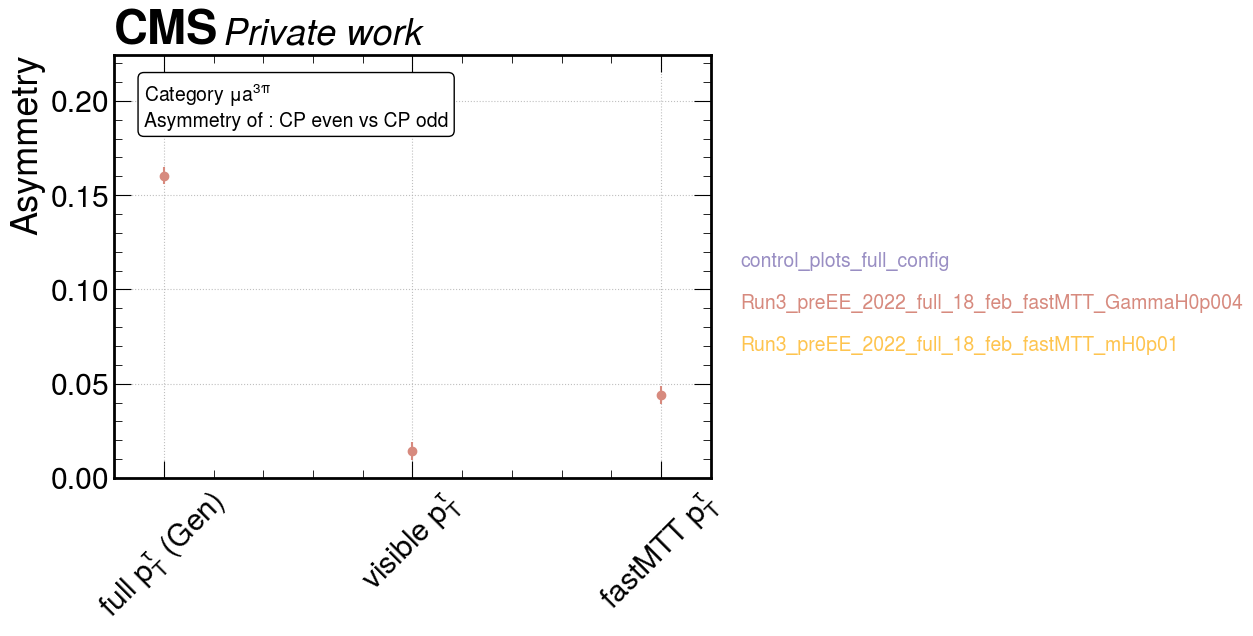

In [115]:
#compare_asymmetries(data_storage)
compare_asymmetries(data_storage, 
                    selected_cats=['$\\mu a^{3\\pi}_{1}$'],
                    selected_datasets=['control_plots_full_config',
                                       'Run3_preEE_2022_full_18_feb_fastMTT_GammaH0p004',
                                       'Run3_preEE_2022_full_18_feb_fastMTT_mH0p01'],
                    selected_tags=['IPPV Gen', 'IPPV Reco', 'IPPV fastMTT'],
                    selected_keys=['cp_even_vs_cp_odd'])

In [88]:
# Before saving: convert defaultdict to dict
data_storage_dict = {k: dict(v) for k, v in data_storage.items()}

# Save data_storage to YAML
with open("data_storage.pkl", "wb") as file:
    pickle.dump(data_storage_dict, file) 


- take dataset legend away -> textbox
- change x axis ticks to physical names
- remove color/dataset ( still there to debug but #)
- error on % value

todo:
if multiple methods :
o put a colour on it
o make that into a legend

X no, don't do that,

save the legend for ggF, VBF if necessary 